<a href="https://colab.research.google.com/github/derekschirripa/AERO_489_Machine_Learning/blob/main/AERO_489_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


Step 1: Create the node matrix which will place the nodes at an equidistant location to all of its neighboring nodes and then the connectivity matrix that will generate the members for each node.

In [2]:
def node_matrix(width, height, dx):
    x_coords = np.arange(0, width + dx, dx)
    y_coords = np.arange(0, height + dx, dx) #x and y spacing are equidistant in this project
    N = np.array([(x, y) for y in y_coords for x in x_coords])
    return N.T

def connectivity_matrix(width, height, dx):
    N = node_matrix(width, height, dx)
    num_nodes = N.shape[1]

    members = []
    for i, node in enumerate(N.T):
        x, y = node
        if x < width:  # Connect to right neighbor
            right_neighbor = np.where((N[0] == x + dx) & (N[1] == y))[0]
            if right_neighbor:
                members.append((i, right_neighbor[0]))
        if y < height:  # Connect to upper neighbor
            upper_neighbor = np.where((N[0] == x) & (N[1] == y + dx))[0]
            if upper_neighbor:
                members.append((i, upper_neighbor[0]))
        if x < width and y < height:  # Connect to upper-right neighbor (diagonal)
            upper_right_neighbor = np.where((N[0] == x + dx) & (N[1] == y + dx))[0]
            if upper_right_neighbor:
                members.append((i, upper_right_neighbor[0]))
        if x < width and y > 0:  # Connect to lower-right neighbor (diagonal)
            lower_right_neighbor = np.where((N[0] == x + dx) & (N[1] == y - dx))[0]
            if lower_right_neighbor:
                members.append((i, lower_right_neighbor[0]))

    C = np.zeros((len(members), num_nodes))

    for idx, (i, j) in enumerate(members):
        C[idx, i] = 1
        C[idx, j] = -1

    return C

width = 4
height = 1
dot_spacing = 0.25

N = node_matrix(width,height,dot_spacing)
C = connectivity_matrix(width,height,dot_spacing)

print("Node matrix \n",N)
print()
print("Connectivity Matrix \n",C)







Node matrix 
 [[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
  3.5  3.75 4.   0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5
  2.75 3.   3.25 3.5  3.75 4.   0.   0.25 0.5  0.75 1.   1.25 1.5  1.75
  2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.   0.   0.25 0.5  0.75 1.
  1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.   0.   0.25
  0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75
  4.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
  0.25 0.25 0.25 0.25 0.25 0.25 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.75 0.75 0.75 0.75 0.75
  0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.  ]]

Connectivity Matrix 
 [[ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]

Step 2: Plot the structure given the node matrix and connectivity matrix.

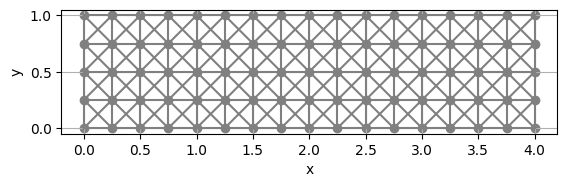

structure has 276 members and 85 nodes


In [3]:

def plot_structure(N, C):
    plt.figure()

    # Plot nodes
    plt.scatter(N[0], N[1], color='grey')

    # Plot connections
    for i in range(C.shape[1]):
        connected_indices = np.where(C[:, i] != 0)[0]
        for idx in connected_indices:
            if C[idx, i] == 1:  # Connection towards the node
                other_node_idx = np.where(C[idx] == -1)[0][0]
                plt.plot([N[0, i], N[0, other_node_idx]],[N[1, i], N[1, other_node_idx]], color='grey')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

# Plot the structure
plot_structure(N, C)


m,n = C.shape

print(f"structure has {m} members and {n} nodes")





Step 3: Minimize mass using cvxpy.


In [10]:
lam = cp.Variable(m) #force densities of the bars (compression)
gam = cp.Variable(m) #force densities of the cables (tension)
R = cp.Variable((2,n)) #Reaction forces at the nodes

M = N@C.T #Member Matrix
b = [] #list of all the Euclidean norms (magnitudes) of each of the member vectors
for i in range(m):
  b.append(np.sqrt(M[:,i][0]**2 + M[:,i][1]**2))

P = 700 #magnitude of the external force in N



Fext = np.zeros((2,n)) #external forces are enacted at the nodes
Fext[1,50] = -P #the external force is only enacted at the 50th node (forced-coded in) in the negative y-direction

ii = [] #free nodes

for i in range(n):
  if N[0,i] == 0:
    continue
  ii.append(i) #free nodes are all the nodes except the ones at x = 0

#constraints are the equilibrium constraints and that the force densities should be positive. The equilibrium constraint has distinctions between bars and cables which will come out of the optimization

Constraints = [N@C.T@cp.diag(gam)@C - N@C.T@cp.diag(lam)@C - Fext - R == 0, R[:,ii] == 0, lam >=0, gam >= 0]

Cost = cp.norm1(cp.multiply(gam,b)) + cp.norm1(cp.multiply(lam,b)) #minimize the 1 norm will output the mimimum mass strucutre
prob = cp.Problem(cp.Minimize(Cost), Constraints)
prob.solve()

weight_bar = [] #the next iteration is now going to weight the inverses of the compressive (bars) and tensile (cables) force densities
weight_cable =[]

#cannot invert elementwise each force because some are very close to zero (1e-23) which will blow up the weights, so we constrain the weights to not invert the very small values

for i in range(len(lam.value)):
  if lam.value[i] <= 0:
    weight_bar.append(0)
  else:
    weight_bar.append(lam.value[i]**-1)

for i in range(len(gam.value)):
  if gam.value[i] <= 0:
    weight_cable.append(0)
  else:
    weight_cable.append(gam.value[i]**-1)

Cost = cp.norm1(cp.multiply(lam,cp.multiply(b,weight_bar))) + cp.norm1(cp.multiply(gam,cp.multiply(b,weight_cable))) #minimize the new cost function
prob = cp.Problem(cp.Minimize(Cost), Constraints)
prob.solve()






52.435150745903556

Step 4: Plot the structure with the bars in compression and the cables in tension.

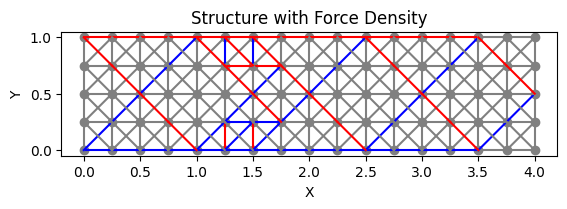

In [11]:
def plot_structure_with_force_density(N, C, sig_b, sig_s):
    ax = plt.figure()

    # Plot nodes
    plt.scatter(N[0], N[1], color='grey')

    # Plot connections
    for i in range(C.shape[1]):
        connected_indices = np.where(C[:, i] != 0)[0]
        for idx in connected_indices:
            if C[idx, i] == 1:  # Connection towards the node
                other_node_idx = np.where(C[idx] == -1)[0][0]
                color = 'blue' if sig_b[idx] > 1e-3 else 'red' if sig_s[idx] > 1e-3 else 'grey' #getting rid of the members where the force densities are less than 0.001
                plt.plot([N[0, i], N[0, other_node_idx]],
                         [N[1, i], N[1, other_node_idx]], color=color)

    plt.title("Structure with Force Density")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


plot_structure_with_force_density(N, C, lam.value, gam.value)

force_density_bars = []
force_density_cables = []

for i in lam.value:
  if i > 1e-3:
    force_density_bars.append(i)

for i in gam.value:
  if i > 1e-3:
    force_density_cables.append(i)




Step 6: We will now compute the mass of the structure and the minimum cross-sectional radius of the members

In [12]:
# the material is steel so the density, yield stress, and Young's Modulus are given

rho = 7850 #kg/m^3
E = 200e9 #Pa
sig_yield = 250e6 #Pa

A_cables = []
A_bars = []
m_bars = 0
m_cables = 0

for i in range(len(b)):
  if gam.value[i] > 1e-3:
    A_cable = gam.value[i]*b[i]/sig_yield
    A_cables.append(A_cable)
    m_cables += rho*A_cable*b[i]
  if lam.value[i] > 1e-3:
    beta = (np.pi*E)/(4*b[i]**2)
    A_bar = np.sqrt(lam.value[i]*b[i]/beta)
    A_bars.append(A_bar) #the bars will buckle before yielding so their areas are limited by the buckling stress
    m_bars += rho*A_bar*b[i]

m_structure = m_bars + m_cables



print("minimum mass of the structure: \n",m_structure,'kg')

radii_bars = np.array([1e3*np.sqrt(i/np.pi) for i in A_bars])
radii_cables = np.array([1e3*np.sqrt(i/np.pi) for i in A_cables])



print('radii of the bars \n',radii_bars.T,'mm')


print('radii of the cables \n',radii_cables.T,'mm')







minimum mass of the structure: 
 1.925283727554865 kg
radii of the bars 
 [3.15251107 2.51343905 3.15251107 3.15251107 3.15251107 2.89817503
 2.51343905 2.82283335 2.11354185 2.74092473 2.11354185 2.74092472
 2.74092471 2.7409247  2.30483377 2.51343905 2.30483377 2.30483377
 2.30483377 2.51343905 2.51343905 1.62976356 2.11354192 1.93812642
 2.51343898 2.51343905 2.51343905 2.51343905 2.11354192 2.51343898
 2.51343905 2.51343905 1.62976356 1.62976356 2.51343896 2.51343905] mm
radii of the cables 
 [0.47203486 0.47203485 0.79386486 0.79386481 0.79386486 0.79386486
 0.56134725 0.79386482 0.79386486 0.79386486 0.47203486 0.56134725
 0.66755809 0.79386482 0.79386486 0.79386486 1.76619277 0.79386486
 1.76619277 1.76619277 1.76619277 1.49270533 0.79386486 1.41610462
 0.56134721 1.33511625 0.56134721 1.33511624 1.33511622 1.33511621
 0.94406974 0.79386486 0.94406974 0.94406974 0.94406974 0.79386486] mm


In conclusion, the minimum mass of the structure is about 2 kg if a tip force of 750 N is exerted in the downward direction. This makes sense since a 4 meter long cantilever beam can withstand a lot of deflection. To carry this further, I can create constraints where the end nodes can have reaction moments on it which is more realistic for a cantilever beam delfection problem. This would require to expand the equilibrium equation to include moments. To apply specifically to an airfoil, I ould modifiy the code to instead plot a airfoil spline where the nodes that are outside of the border would be discarded. I could apply constraints where the surface nodes are the only nodes that will have a the lift force applied to it. Lastly, I could constrain the nodes to not be able to move. This code would then output the minimum mass structure for an airfoil truss.